<a href="https://colab.research.google.com/github/ngupta23/inventory-deterministic/blob/main/Inventory%20Management%20-%20Deterministic%20(Class%20Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Article Link
https://towardsdatascience.com/inventory-management-for-retail-deterministic-demand-311682c02518


**Other References:**
1. https://github.com/ngupta23/supply_chain_basics/issues/1
 
**Overview**
1.   This simulates a Constant Demand, Constant Lead Time Scenario (Very Ideal) - Refer to [1].
2.   Types of Inventory Strategies per [1]
    
    [A] **"Periodic Review System"** where the replenishment is done every N days, and

    [B] **"Continuous Review System"** where a fixed number of orders are placed when the inventory falls to a certain level.
3.  This example is a mix of [A] and [B], where we place a fixed number of orders every N days. This is probably only ok for this ideal scenario, but may not be OK for others. We will start to evaluate from this ideal scenatio anyway and build up from there.

In [1]:
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

### Functions

In [3]:
class DeterministicDemandSimulator():
  def __init__(self, total_demand, total_time, replenishment_quantity, cost_of_placing_order, unit_cost, holding_cost_per_unit, manufacturing_cycle_time):
    """
    total_demand: Total Demand (units/year)
    total_time: Number of days of sales per year (days)
    replenishment_quantity: Order Quantity
    unit_cost: Purchase cost of the product ($/unit)
    cost_of_placing_order:  Cost of placing an order (/order)
    holding_cost_per_unit: Holding Cost (% unit cost per year)
    manufacturing_cycle_time: Lead Time between ordering and receiving
    """
    self.total_demand = total_demand
    self.total_time = total_time
    self.replenishment_quantity = replenishment_quantity
    self.unit_cost = unit_cost
    self.cost_of_placing_order = cost_of_placing_order
    self.holding_cost_per_unit = holding_cost_per_unit
    self.manufacturing_cycle_time = manufacturing_cycle_time


    self.demand_per_day = None
    self.replenishment_period = None
    self.num_orders = None
    self.ideal_order_cost = None
    self.ideal_holding_cost = None
    self.ideal_relevant_cost = None
    self.sim_results = None


  #############################
  #### Static Calculations ####
  #############################

  def _set_demand_per_day(self):
    self.demand_per_day = self.total_demand/self.total_time

  def _set_replenishment_period(self):
    """Set the time between orders
    """
    self.replenishment_period = math.floor(self.replenishment_quantity/self.demand_per_day)

  def _set_number_of_orders(self):
    """Set the number of prelenishment orders placed in the "total_time" days
    """
    self.num_orders = self.total_demand/self.replenishment_quantity

  def _set_ideal_order_cost(self):
    """
    Back of the envelope calculation (see article for details)
    """
    self.ideal_order_cost = self.cost_of_placing_order * self.num_orders

  def _set_ideal_holding_cost(self):
    """
    Back of the envelope calculation (see article for details)
    """
    self.ideal_holding_cost = self.holding_cost_per_unit * (self.replenishment_quantity / 2)

  def _set_ideal_relevant_cost(self):
    """
    Back of the envelope calculation (see article for details)
    """
    self.ideal_relevant_cost = self.ideal_order_cost + self.ideal_holding_cost   

  def print(self):
    """
    """
    print(f"Demand per day: {self.demand_per_day} units")
    print(f"Replenishment Period: {self.replenishment_period} days")
    print(f"Units per Order: {self.replenishment_quantity} units")
    print(f"Number of orders in the year: {self.num_orders}")

    print(f"Total Order Cost for the year (Ideal back of envelope calculation): ${round(self.ideal_order_cost)}")
    print(f"Holding Cost for the year (Ideal back of envelope calculation): ${round(self.ideal_holding_cost)}")
    print(f"Total Relevant Cost for the year (Ideal back of envelope calculation): ${round(self.ideal_relevant_cost)}")

  def setup(self, verbose=True):
    """
    """
    if verbose:
      print("="*25)
      print("Theoretical Calculations")
      print("="*25)

    self._set_demand_per_day()
    self._set_replenishment_period()
    self._set_number_of_orders()
    self._set_ideal_order_cost()
    self._set_ideal_holding_cost()
    self._set_ideal_relevant_cost()
    if verbose:
      self.print()


  ########################
  #### For Simulation ####
  ########################

  def get_demand_per_day(self):
    """Return Deterministic constant demand
    """
    return self.demand_per_day

  def get_order_quantity_per_day(self, present_day):
      """
      Order Quantity per day
      present_day = current time period
      """
      # Reorder when t = 1 + k x T 
      if ((present_day-1) % self.replenishment_period)==0:
          return self.replenishment_quantity
      else:
          return 0

  def get_order_cost_per_day(self, order):
      """
      Order Cost per day
      order = number of orders placed today
      """
      if order > 0:
        return self.cost_of_placing_order
      else:
          return 0

  def get_holding_cost_per_day(self, ioh):
      """
      Holding Cost per day
      ioh = Inventory no Hand
      """
      # Even when IOH is negative, holding code can not be negative
      return max(ioh * self.holding_cost_per_unit/365, 0)

  def plot(self):
    """
    Plot Simulation Results
    """
    # Plot
    figure, axes = plt.subplots(3, 1)

    self.sim_results.plot(figsize=(20, 12), xlim=[0,300] , x='time', y='demand', ax=axes[0], grid = True, color = 'r')
    self.sim_results.plot.scatter(figsize=(20, 12), xlim=[0,300], x='time', y='order', ax=axes[1], grid = True, color ='b')
    self.sim_results.plot(figsize=(20, 15), xlim=[0, 300], x='time', y='ioh', ax=axes[2], grid = True, color = 'g')

    plt.xlabel('Time (day)')
    plt.ylabel('ioh')
    plt.xticks(rotation=90)

    plt.show() 

  def sim(self, verbose=True):
      """
      """
      if verbose:
        print("\n")
        print("="*25)
        print("Simulation Results")
        print("="*25)

      df_sim = pd.DataFrame({'time': np.array(range(1, self.total_time+1))})
      
      # Demand Function ("demand" = demand per day)
      df_sim['demand'] = df_sim['time'].apply(lambda t: self.get_demand_per_day())
      
      # Order Function ("order" = how many units to order each day?)
      df_sim['order'] = df_sim['time'].apply(lambda t: self.get_order_quantity_per_day(t))
      
      # Inventory on Hand = Order - Demand
      df_sim['ioh'] = df_sim['order'].cumsum().shift(self.manufacturing_cycle_time).fillna(0) - df_sim['demand'].cumsum().fillna(0)

      # Order Cost
      df_sim['order_cost'] = df_sim['order'].apply(lambda order: self.get_order_cost_per_day(order))

      # Holding Cost
      df_sim['holding_cost'] = df_sim['ioh'].apply(lambda ioh: self.get_holding_cost_per_day(ioh))

      # Relevant Cost
      df_sim['relevant_cost'] = df_sim['order_cost'] + df_sim['holding_cost']
      
      self.sim_results = df_sim

      # Print Results
      if verbose: 
        demand_during_replenishment_period = self.demand_per_day * self.replenishment_period
        print(f"Demand during Replenishment Period: {demand_during_replenishment_period} units")

        avg_ioh = round(df_sim['ioh'].mean(),2)
        print(f"Average IOH for Replenishment Period = {self.replenishment_period} days is {avg_ioh} units")

        self.exact_order_cost = round(self.sim_results["order_cost"].sum())
        self.exact_holding_cost = round(self.sim_results["holding_cost"].sum())
        self.exact_relevant_cost = round(self.sim_results["relevant_cost"].sum())
        print(f"Total Order Costs (Exact simulated): ${self.exact_order_cost}")
        print(f"Total Holding Costs (Exact simulated): ${self.exact_holding_cost}")
        print(f"Total Relevant Costs (Exact simulated): ${self.exact_relevant_cost}")
      
        self.plot()
       
  def run(self, verbose=True):
      self.setup(verbose=verbose)
      self.sim(verbose=verbose)  

## Fixed Variables

In [4]:
TOTAL_DEMAND = 2000
TOTAL_TIME = 365
UNIT_COST = 50
COST_OF_PLACING_ORDER = 500
HOLDING_COST_PER_UNIT = 12.5

## Initial Rule (Assuming 0 Manufacturing Cycle Time / Lead Time)



Theoretical Calculations
Demand per day: 5.47945205479452 units
Replenishment Period: 10 days
Units per Order: 54.8 units
Number of orders in the year: 36.496350364963504
Total Order Cost for the year (Ideal back of envelope calculation): $18248
Holding Cost for the year (Ideal back of envelope calculation): $342
Total Relevant Cost for the year (Ideal back of envelope calculation): $18591


Simulation Results
Demand during Replenishment Period: 54.794520547945204 units
Average IOH for Replenishment Period = 10 days is 24.95 units
Total Order Costs (Exact simulated): $18500
Total Holding Costs (Exact simulated): $312
Total Relevant Costs (Exact simulated): $18812


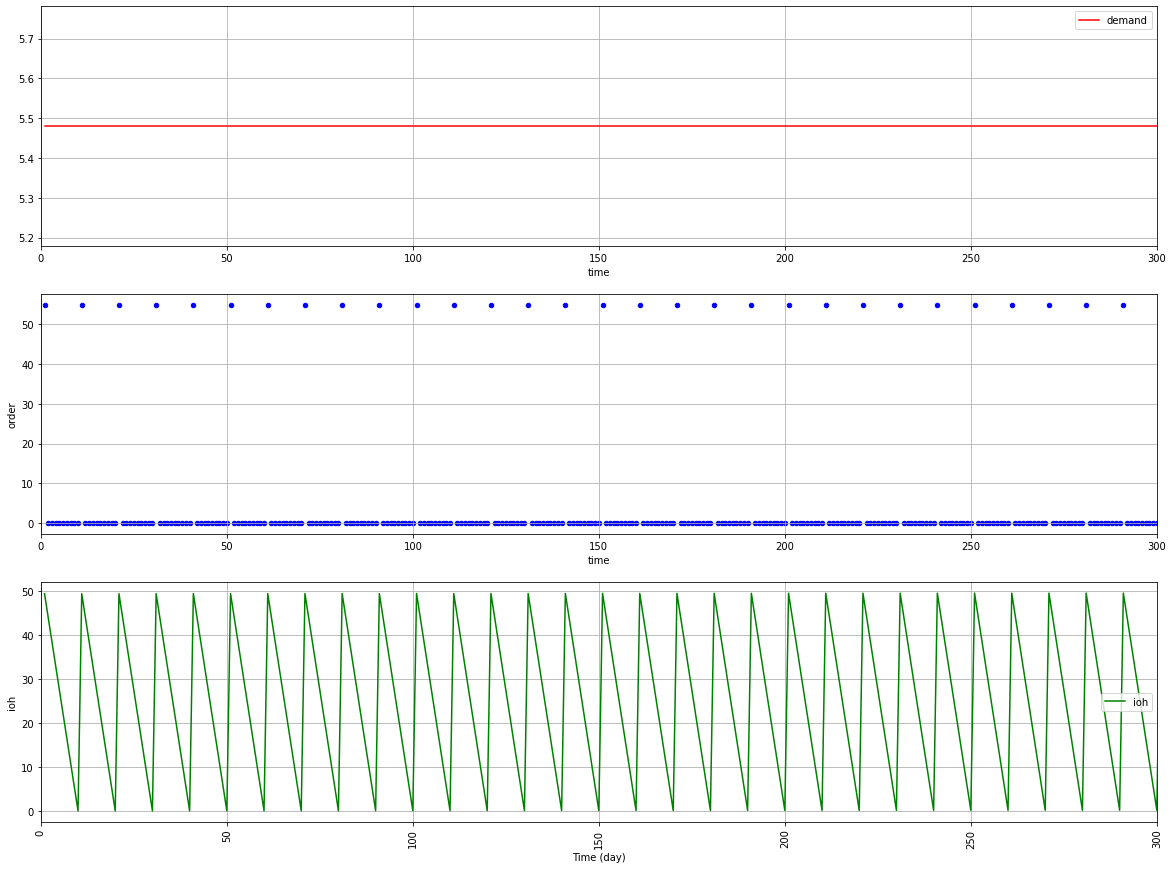

In [5]:
dds = DeterministicDemandSimulator(
  total_demand = TOTAL_DEMAND,
  total_time = TOTAL_TIME,
  replenishment_quantity = 54.8,
  unit_cost = UNIT_COST,
  cost_of_placing_order = COST_OF_PLACING_ORDER,
  holding_cost_per_unit = HOLDING_COST_PER_UNIT,
  manufacturing_cycle_time = 0 
)
dds.run()

In [6]:
dds.sim_results

,time,demand,order,ioh,order_cost,holding_cost,relevant_cost
0,1,5.479452,54.8,49.320548,500,1.689060,501.689060
1,2,5.479452,0.0,43.841096,0,1.501407,1.501407
2,3,5.479452,0.0,38.361644,0,1.313755,1.313755
3,4,5.479452,0.0,32.882192,0,1.126102,1.126102
4,5,5.479452,0.0,27.402740,0,0.938450,0.938450
...,...,...,...,...,...,...,...
360,361,5.479452,54.8,49.517808,500,1.695815,501.695815
361,362,5.479452,0.0,44.038356,0,1.508163,1.508163
362,363,5.479452,0.0,38.558904,0,1.320510,1.320510
363,364,5.479452,0.0,33.079452,0,1.132858,1.132858


## EOQ (Economic Order Quantity)

In [7]:
class FindEOQ():
  def __init__(self, total_demand, total_time, cost_of_placing_order, unit_cost, holding_cost_per_unit, manufacturing_cycle_time):
    """
    total_demand: Total Demand (units/year)
    total_time: Number of days of sales per year (days)
    replenishment_quantity: Order Quantity
    unit_cost: Purchase cost of the product ($/unit)
    cost_of_placing_order:  Cost of placing an order (/order)
    holding_cost_per_unit: Holding Cost (% unit cost per year)
    manufacturing_cycle_time: Lead Time between ordering and receiving
    """
    self.total_demand = total_demand
    self.total_time = total_time
    self.unit_cost = unit_cost
    self.cost_of_placing_order = cost_of_placing_order
    self.holding_cost_per_unit = holding_cost_per_unit
    self.manufacturing_cycle_time = manufacturing_cycle_time

    self.sweep_results = None

  def sweep(self, Qs=None):
    if Qs is None:
      q_max = int(self.total_demand/2)
      q_min = int(q_max/20)
      Qs = np.arange(q_min, q_max, 10)
    
    holding_costs = []
    order_costs = []
    relevant_costs = []

    for Q in Qs:
      # Set Simulator
      dds = DeterministicDemandSimulator(
        total_demand = self.total_demand,
        total_time = self.total_time,
        replenishment_quantity = Q,  # This is Swept
        unit_cost = self.unit_cost,
        cost_of_placing_order = self.cost_of_placing_order,
        holding_cost_per_unit = self.holding_cost_per_unit,
        manufacturing_cycle_time = self.manufacturing_cycle_time 
      )
      dds.run(verbose=False)
      
      # Save results
      holding_costs.append(dds.sim_results["holding_cost"].sum())
      order_costs.append(dds.sim_results["order_cost"].sum())
      relevant_costs.append(dds.sim_results["relevant_cost"].sum())

    self.sweep_results = pd.DataFrame({
      "Q": Qs,
      "Holding Cost": holding_costs,
      "Order Cost": order_costs,
      "Relevant Cost": relevant_costs
    })
    
    return self

  def find_eoq(self):
    """
    Find the Economic Order Quantity
    """
    self.eoq = self.sweep_results.sort_values("Relevant Cost").iloc[0]["Q"]
    print(f"Economic Order Quantity (EOQ) = {self.eoq}")

    return self

  def plot_eoq(self):
    """
    Visualize EOQ Tradeoffs
    """
    #### Plot ----

    figure, axes = plt.subplots(1, 1, figsize=(15,8))

    self.sweep_results.plot.line(x='Q', y='Holding Cost', ax=axes, grid = True, color ='r')
    self.sweep_results.plot.line(x='Q', y='Order Cost', ax=axes, grid = True, color ='b')
    self.sweep_results.plot.line(x='Q', y='Relevant Cost', ax=axes, grid = True, color ='black')

    plt.xlabel('Order Quantity (units/order)')
    plt.ylabel('Costs ($)')

    plt.show()

    
  def run(self, Qs=None):
    (
      self.sweep(Qs=Qs)
      .find_eoq()
      .plot_eoq()
    )
    return self.eoq

  def simulate_at_eoq(self):
    dds = DeterministicDemandSimulator(
      total_demand = self.total_demand,
      total_time = self.total_time,
      replenishment_quantity = self.eoq,
      unit_cost = self.unit_cost,
      cost_of_placing_order = self.cost_of_placing_order,
      holding_cost_per_unit = self.holding_cost_per_unit,
      manufacturing_cycle_time = self.manufacturing_cycle_time 
    )
    dds.run()
    
    return dds


  

### Find EOQ

Economic Order Quantity (EOQ) = 400.0


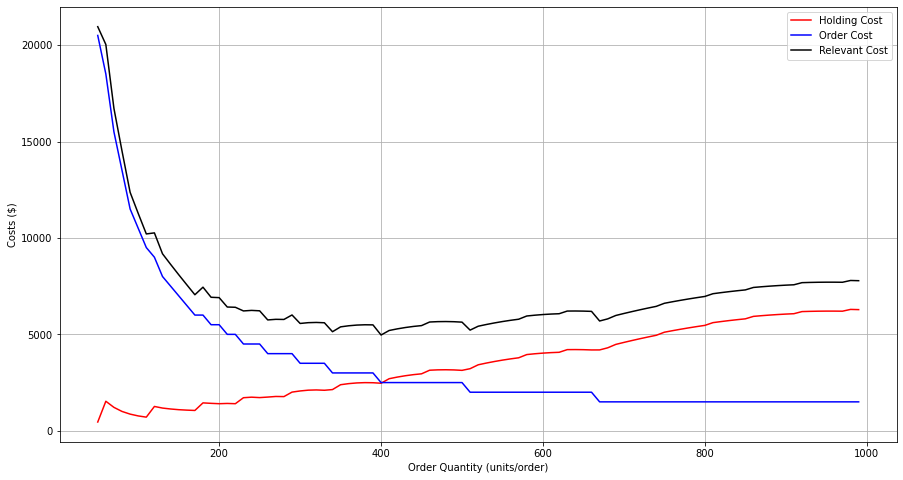

In [8]:
eoq_finder = FindEOQ(
    total_demand = TOTAL_DEMAND,
    total_time = TOTAL_TIME,
    unit_cost = UNIT_COST,
    cost_of_placing_order = COST_OF_PLACING_ORDER,
    holding_cost_per_unit = HOLDING_COST_PER_UNIT,
    manufacturing_cycle_time = 0
)
eoq = eoq_finder.run()

### Visualize EOQ

Theoretical Calculations
Demand per day: 5.47945205479452 units
Replenishment Period: 73 days
Units per Order: 400.0 units
Number of orders in the year: 5.0
Total Order Cost for the year (Ideal back of envelope calculation): $2500
Holding Cost for the year (Ideal back of envelope calculation): $2500
Total Relevant Cost for the year (Ideal back of envelope calculation): $5000


Simulation Results
Demand during Replenishment Period: 400.0 units
Average IOH for Replenishment Period = 73 days is 197.26 units
Total Order Costs (Exact simulated): $2500
Total Holding Costs (Exact simulated): $2466
Total Relevant Costs (Exact simulated): $4966


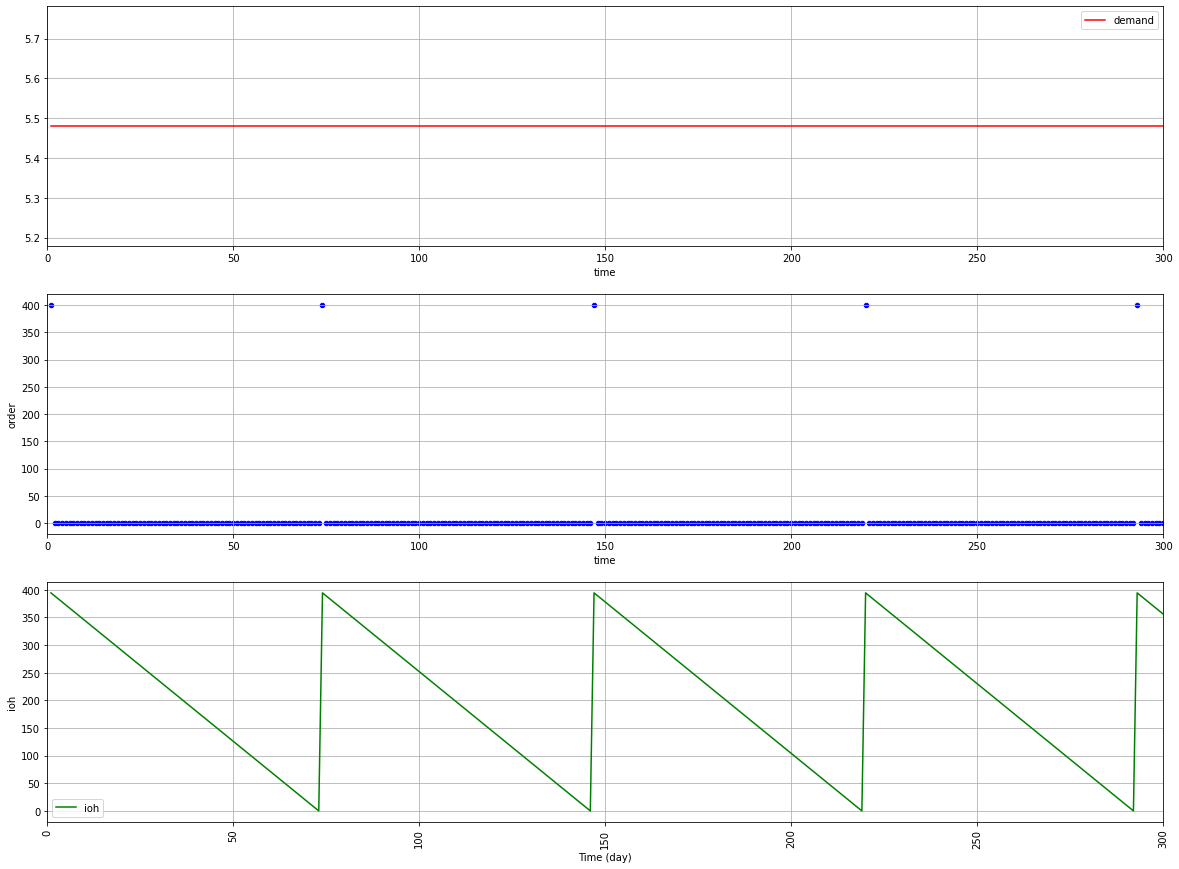

In [9]:
dds = eoq_finder.simulate_at_eoq()

In [10]:
dds.sim_results

,time,demand,order,ioh,order_cost,holding_cost,relevant_cost
0,1,5.479452,400.0,3.945205e+02,500,13.510978,513.510978
1,2,5.479452,0.0,3.890411e+02,0,13.323325,13.323325
2,3,5.479452,0.0,3.835616e+02,0,13.135673,13.135673
3,4,5.479452,0.0,3.780822e+02,0,12.948020,12.948020
4,5,5.479452,0.0,3.726027e+02,0,12.760368,12.760368
...,...,...,...,...,...,...,...
360,361,5.479452,0.0,2.191781e+01,0,0.750610,0.750610
361,362,5.479452,0.0,1.643836e+01,0,0.562957,0.562957
362,363,5.479452,0.0,1.095890e+01,0,0.375305,0.375305
363,364,5.479452,0.0,5.479452e+00,0,0.187652,0.187652


## With 25 day Manufacturing Time (Lead Time)

Theoretical Calculations
Demand per day: 5.47945205479452 units
Replenishment Period: 73 days
Units per Order: 400.0 units
Number of orders in the year: 5.0
Total Order Cost for the year (Ideal back of envelope calculation): $2500
Holding Cost for the year (Ideal back of envelope calculation): $2500
Total Relevant Cost for the year (Ideal back of envelope calculation): $5000


Simulation Results
Demand during Replenishment Period: 400.0 units
Average IOH for Replenishment Period = 73 days is 60.27 units
Total Order Costs (Exact simulated): $2500
Total Holding Costs (Exact simulated): $1058
Total Relevant Costs (Exact simulated): $3558


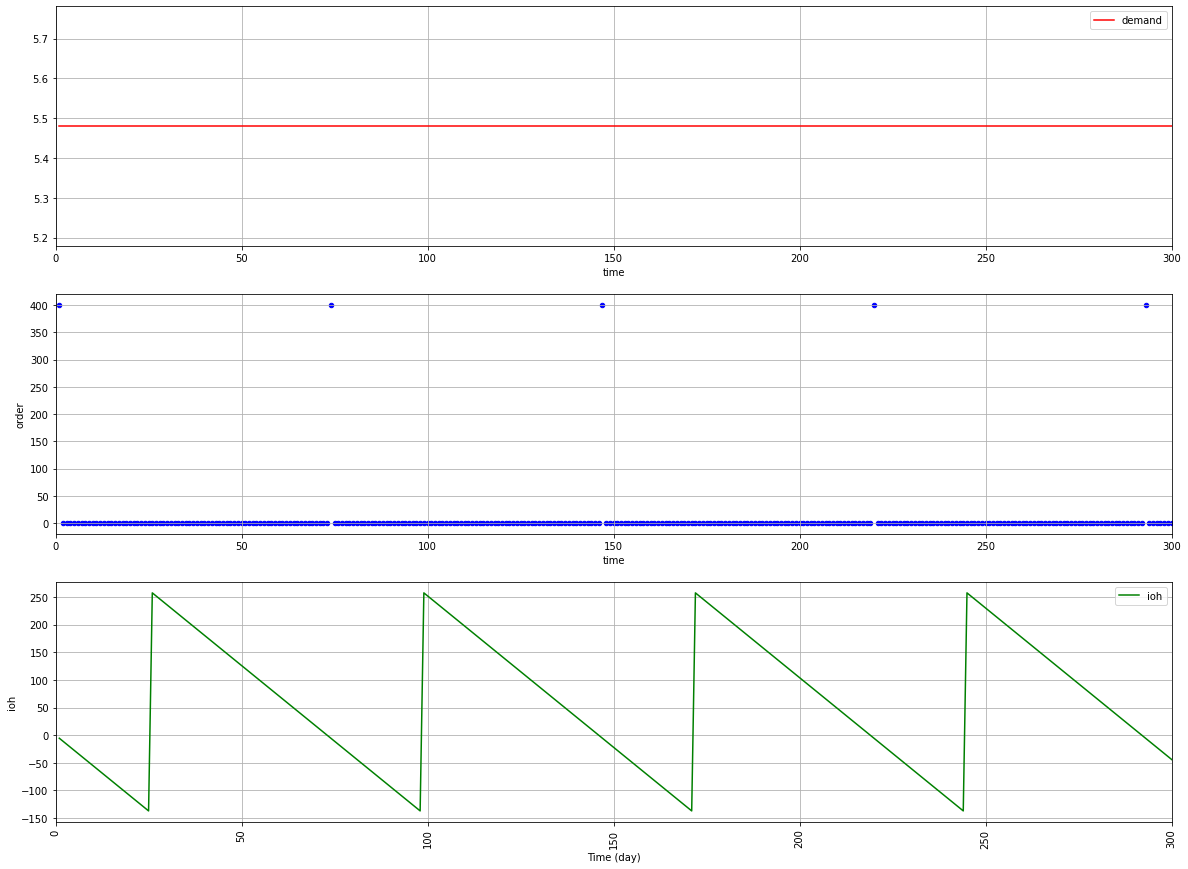

In [12]:
dds = DeterministicDemandSimulator(
  total_demand = TOTAL_DEMAND,
  total_time = TOTAL_TIME,
  replenishment_quantity = eoq,
  unit_cost = UNIT_COST,
  cost_of_placing_order = COST_OF_PLACING_ORDER,
  holding_cost_per_unit = HOLDING_COST_PER_UNIT,
  manufacturing_cycle_time = 25 
)
dds.run()

In [13]:
dds.sim_results

,time,demand,order,ioh,order_cost,holding_cost,relevant_cost
0,1,5.479452,400.0,-5.479452e+00,500,0.000000,500.000000
1,2,5.479452,0.0,-1.095890e+01,0,0.000000,0.000000
2,3,5.479452,0.0,-1.643836e+01,0,0.000000,0.000000
3,4,5.479452,0.0,-2.191781e+01,0,0.000000,0.000000
4,5,5.479452,0.0,-2.739726e+01,0,0.000000,0.000000
...,...,...,...,...,...,...,...
360,361,5.479452,0.0,2.191781e+01,0,0.750610,0.750610
361,362,5.479452,0.0,1.643836e+01,0,0.562957,0.562957
362,363,5.479452,0.0,1.095890e+01,0,0.375305,0.375305
363,364,5.479452,0.0,5.479452e+00,0,0.187652,0.187652


We start off with Stockouts since the order we place on Day 1 is not available until Day 26.

**TODO: Add Stockout Cost**

## Reoptimize based on Lead Time

Economic Order Quantity (EOQ) = 670.0


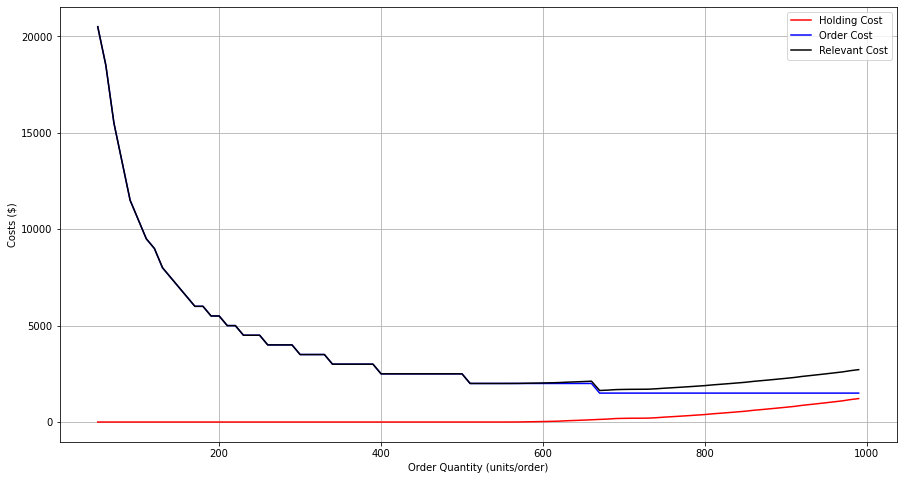

In [17]:
eoq_finder = FindEOQ(
    total_demand = TOTAL_DEMAND,
    total_time = TOTAL_TIME,
    unit_cost = UNIT_COST,
    cost_of_placing_order = COST_OF_PLACING_ORDER,
    holding_cost_per_unit = HOLDING_COST_PER_UNIT,
    manufacturing_cycle_time = 100
)
eoq = eoq_finder.run()

Theoretical Calculations
Demand per day: 5.47945205479452 units
Replenishment Period: 122 days
Units per Order: 670.0 units
Number of orders in the year: 2.985074626865672
Total Order Cost for the year (Ideal back of envelope calculation): $1493
Holding Cost for the year (Ideal back of envelope calculation): $4188
Total Relevant Cost for the year (Ideal back of envelope calculation): $5680


Simulation Results
Demand during Replenishment Period: 668.4931506849315 units
Average IOH for Replenishment Period = 122 days is -215.26 units
Total Order Costs (Exact simulated): $1500
Total Holding Costs (Exact simulated): $137
Total Relevant Costs (Exact simulated): $1637


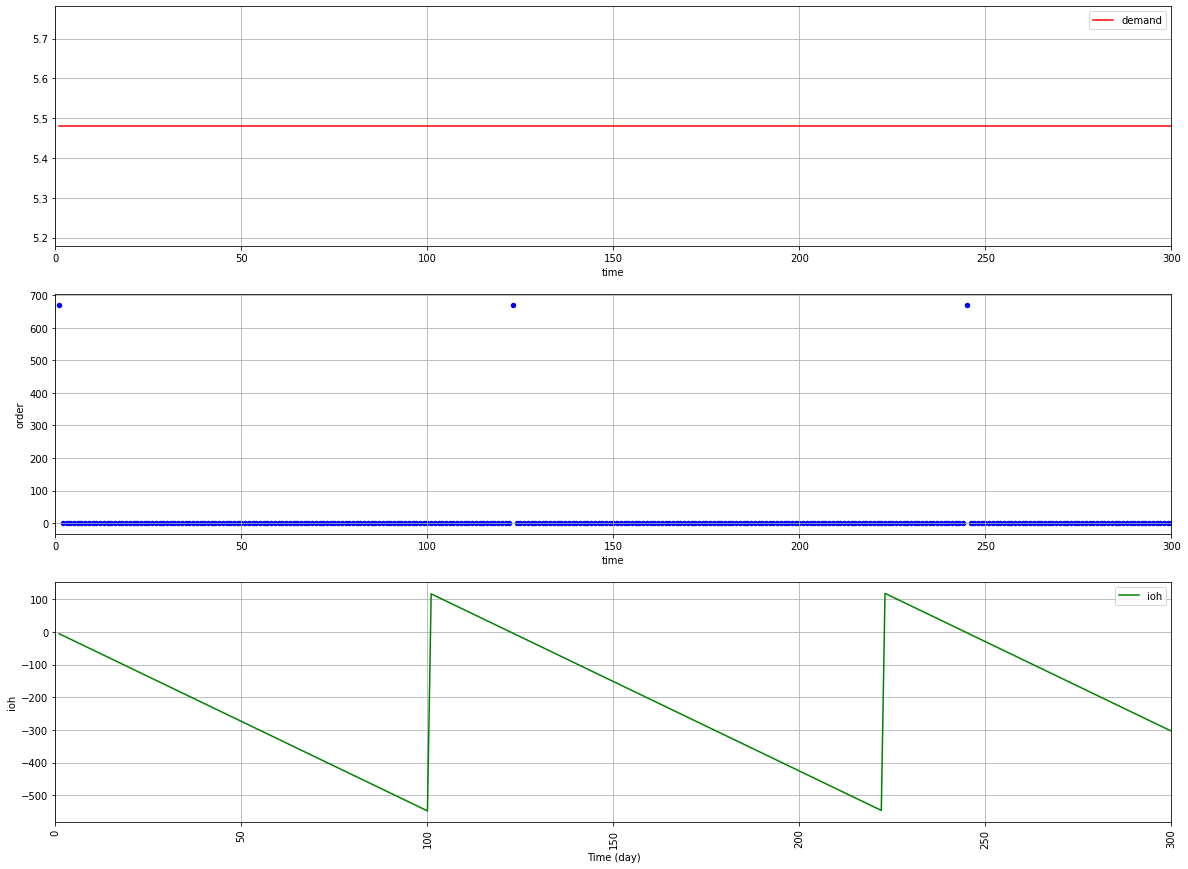

In [18]:
dds = eoq_finder.simulate_at_eoq()